## TODO

Flash energy calculation

In [1]:
import glob
import numpy as np
import datetime
import xarray as xr

from pyxlma.lmalib.io import read as lma_read
from pyxlma.plot.xlma import XlmaPlot

from pyxlma.lmalib.flash.cluster import cluster_flashes

%matplotlib inline

In [2]:
# files_grabbed = list(sorted(glob.glob('../test/vanna/kinda/L*')))
# lma_data, starttime = lma_read.dataset(files_grabbed)
# print(files_grabbed)

lma_data, starttime = lma_read.dataset(['/data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.dat.gz'])

# lf = read.lmafile(files_grabbed[-1])
# Station info comes from the last file read.
# stations = lma_file.stations

# Will need to add logic to check for existing data and do something else if it is
# if len(lma_data) > 0:
#     lma_data.sort_values('Datetime', inplace=True)

dttuple = [starttime, starttime+datetime.timedelta(minutes=10)]
# dttuple = lma_data.Datetime.min(), lma_data.Datetime.max()
tstring = 'LMA {}-{}'.format(dttuple[0].strftime('%H%M'),
                                      dttuple[1].strftime('%H%M UTC %d %B %Y '))
print(tstring, dttuple)

LMA 2100-2110 UTC 24 May 2020  [datetime.datetime(2020, 5, 24, 21, 0), datetime.datetime(2020, 5, 24, 21, 10)]


In [3]:
# Change the dictionaries below to a consistent set of coordinates
# and adjust grid_spatial_coords in the call to events_to_grid to 
# change what is gridded (various time series of 1D, 2D, 3D grids)

event_coord_names = {
    'event_latitude':'grid_latitude_edge',
    'event_longitude':'grid_longitude_edge',
#     'event_altitude':'grid_altitude_edge',
    'event_time':'grid_time_edge',
}

flash_ctr_names = {
    'flash_init_latitude':'grid_latitude_edge',
    'flash_init_longitude':'grid_longitude_edge',
#     'flash_init_altitude':'grid_altitude_edge',
    'flash_time_start':'grid_time_edge',
}
flash_init_names = {
    'flash_center_latitude':'grid_latitude_edge',
    'flash_center_longitude':'grid_longitude_edge',
#     'flash_center_altitude':'grid_altitude_edge',
    'flash_time_start':'grid_time_edge',
}

# Oklahoma
# lat_range = (34.5, 36.5, 0.02)
# lon_range = (-100, -98.01, 0.02)
# alt_range = (0, 18e3, 1.0e3)

# Houston
29.7600000 -95.3700000
lat_range = (27.75, 31.75, 0.025)
lon_range = (-97.37, -93.37, 0.025)
alt_range = (0, 18e3, 1.0e3)


grid_dt = np.asarray(60, dtype='m8[s]')
grid_t0 = np.asarray(dttuple[0]).astype('datetime64[ns]')
grid_t1 = np.asarray(dttuple[1]).astype('datetime64[ns]')
time_range = (grid_t0, grid_t1+grid_dt, grid_dt)

grid_edge_ranges ={
    'grid_latitude_edge':lat_range,
    'grid_longitude_edge':lon_range,
#     'grid_altitude_edge':alt_range,
    'grid_time_edge':time_range,
}
grid_center_names ={
    'grid_latitude_edge':'grid_latitude',
    'grid_longitude_edge':'grid_longitude',
#     'grid_altitude_edge':'grid_altitude',
    'grid_time_edge':'grid_time',
}

In [4]:
ds = cluster_flashes(lma_data)

<xarray.Dataset>
Dimensions:                              (number_of_flashes: 41779)
Dimensions without coordinates: number_of_flashes
Data variables:
    flash_distance_separation_threshold  float64 0.0
    flash_time_separation_threshold      float64 0.0
    flash_duration_threshold             float64 0.0
    flash_time_merge_threshold           float64 0.0
    network_center_latitude              float64 0.0
    network_center_longitude             float64 0.0
    network_center_altitude              float64 0.0
    flash_id                             (number_of_flashes) uint64 18446744073709551615 ... 18446744073709551615
    flash_time_start                     (number_of_flashes) datetime64[ns] NaT ... NaT
    flash_time_end                       (number_of_flashes) datetime64[ns] NaT ... NaT
    flash_duration                       (number_of_flashes) timedelta64[ns] NaT ... NaT
    flash_init_latitude                  (number_of_flashes) float32 nan ... nan
    flash_init_lon

In [5]:
def rho_br(z, separation, e_0=8.85418782e-12):
    '''
    Compute critical electric field from initiation altitudes.
    From the electric field, compute critical charge density.
    Approximates the electric field at breakdown using the runaway
    breakeven threshold as a function of altitude.

    args: z, separation = initiation and plate separation altitudes in km 
    returns: rho_critical in kV/m
    '''
    z = z*1e-3
    rho_a = 1.208 * np.exp(-(z/8.4))
    efield=(167.*rho_a)*1e3
    sig_crit=2*efield*self.e_0
    rho_crit=sig_crit/separation
    return(rho_crit)

def capacitor_energy(z, d, area, e_0=8.85418782e-12, separation_percentiles=(27,73)):
    separation = np.abs(np.percentile(alt,separation_percentiles[1]) -
                        np.percentile(alt,separation_percentiles[0]))
    rho = rho_br(z, d, e_0)
    w = (rho**2. * d**3. * area)/(2. * e_0) 
    return w


In [6]:
from scipy.spatial import Delaunay, ConvexHull
from scipy.special import factorial
from scipy.spatial.qhull import QhullError


def local_cartesian(lon, lat, alt):
    Re = 6378.137e3           #Earth's radius in m
    latavg, lonavg, altavg = lat.mean(), lon.mean(), alt.mean()
    x = Re * (np.radians(lonavg) - np.radians(lon)) * np.cos(np.radians(latavg))
    y = Re * (np.radians(latavg) - np.radians(lat))
    z = altavg - alt
    return x,y,z

def hull_volume(xyz):
    """ Calculate the volume of the convex hull of 3D (X,Y,Z) LMA data.
        xyz is a (N_points, 3) array of point locations in space. """
    assert xyz.shape[1] == 3
        
    tri = Delaunay(xyz[:,0:3])
    vertices = tri.points[tri.vertices]
    
    # This is the volume formula in 
    # https://github.com/scipy/scipy/blob/master/scipy/spatial/tests/test_qhull.py#L106
    # Except the formula needs to be divided by ndim! to get the volume, cf., 
    # http://en.wikipedia.org/wiki/Simplex#Geometric_properties
    # Credit Pauli Virtanen, Oct 14, 2012, scipy-user list
    
    q = vertices[:,:-1,:] - vertices[:,-1,None,:]
    simplex_volumes = (1.0 / factorial(q.shape[-1])) * np.fromiter(
           (np.linalg.det(q[k,:,:]) for k in range(tri.nsimplex)) , dtype=float)
    # print vertices.shape # number of simplices, points per simplex, coords
    # print q.shape
    
    # The simplex volumes have negative values since they are oriented 
    # (think surface normal direction for a triangle
    volume=np.sum(np.abs(simplex_volumes))
    return volume, vertices, simplex_volumes

def event_hull(ds):
    x,y,z = local_cartesian(ds.event_longitude, ds.event_latitude, ds.event_altitude)
    pointCount = ds.dims['number_of_events']
    area = 0.0
    if pointCount > 2:
        try:
            # find the convex hull and calculate its area
            cvh = ConvexHull(np.vstack((x,y)).T)
            # NOT cvh.area - it is the perimeter in 2D. 
            # cvh.area is the surface area in 3D.
            area = cvh.volume
        except IndexError:
            # tends to happen when a duplicate point causes the point count to
            # drop to 2, leading to a degenerate polygon with no area
            logger.warning('Setting area to 0 for flash with points %s, %s' % (x, y))
        except KeyError:
            # hull indexing has problems here
            logger.warning('Setting area to 0 for flash with points %s, %s' % (x, y))

    volume = 0.0
    if pointCount > 3:
        # Need four points to make at least one tetrahedron.
        try:
            volume, vertices, simplex_volumes = hull_volume(np.vstack((x,y,z)).T)
        except QhullError:
            # this can happen with a degenerate first simplex - all points are
            # coplanar to machine precision. Try again, after adding a tiny amount
            # to the first point.
            print("Perturbing one source to help triangulation for flash with {0} points".format(flash.pointCount))
            # we can tolerate perturbing by no more than 1 m
            machine_eps = 1.0 # np.finfo(x.dtype).eps
            perturb = 2*machine_eps*np.random.random(size=3)-machine_eps
            x[0] += perturb[0]
            y[0] += perturb[1]
            z[0] += perturb[2]
            volume, vertices, simplex_volumes = hull_volume(np.vstack((x,y,z)).T)
    return (x,y,z), area, volume




In [7]:


def flash_stat_iter(fl_gb):    
    for fl_id, ds in fl_gb:
        first_event = np.argmin(ds['event_time'])
        last_event = np.argmax(ds['event_time'])
        init_lon = ds['event_longitude'][first_event]
        init_lat = ds['event_latitude'][first_event]
        init_alt = ds['event_altitude'][first_event]
        ctr_lon = ds['event_longitude'].mean()
        ctr_lat = ds['event_latitude'].mean()
        ctr_alt = ds['event_altitude'].mean()
        n_events = ds.dims['number_of_events']
        init_time = ds['event_time'][first_event]
        end_time = ds['event_time'][last_event]
        total_power = ds.event_power.sum()
        (x,y,z), area, volume = event_hull(ds)
#         mean_stations = ds.event_stations.mean()
#         mean_chi2 = ds.event_chi2.mean()
        
        yield(fl_id, n_events, ctr_lon, ctr_lat, ctr_alt,
              init_lon, init_lat, init_alt,
              init_time.data, end_time.data,
              area*1e-6, volume*1e-9,
              total_power, # mean_stations, mean_chi2
             )


def flash_stats(ds):
    fl_gb = ds.groupby('event_parent_flash_id')
    n_flashes = len(fl_gb.groups)
    fl_stat_dtype = [('fl_id', 'u8'),
                     ('flash_event_count', 'u8'),
                     ('flash_center_longitude', 'f8'),
                     ('flash_center_latitude', 'f8'),
                     ('flash_center_altitude', 'f8'),
                     ('flash_init_longitude', 'f8'),
                     ('flash_init_latitude', 'f8'),
                     ('flash_init_altitude', 'f8'),
                     ('flash_time_start', 'datetime64[ns]'),
                     ('flash_time_end', 'datetime64[ns]'),
                     ('flash_area','f8'),
                     ('flash_volume','f8'),
                     ('event_total_power','f8'),
#                      ('event_mean_stations', 'f4'),
#                      ('event_mean_chi2', 'f4'),
                    ]
    ev_iter = flash_stat_iter(fl_gb)
    agg = np.fromiter(ev_iter, dtype=fl_stat_dtype, count=n_flashes)
    ds=ds.set_index(number_of_flashes='flash_id')
    to_assign = ('flash_event_count',
                 'flash_center_longitude',
                 'flash_center_latitude',
                 'flash_center_altitude',
                 'flash_init_longitude',
                 'flash_init_latitude',
                 'flash_init_altitude',
                 'flash_time_start',
                 'flash_time_end',
                 'flash_area',
                 'flash_volume',
                )
    for var in to_assign:
        ds[var][agg['fl_id']] = agg[var]
    ds['flash_duration'] = ds['flash_time_start'] - ds['flash_time_end']
    ds.reset_index('number_of_flashes')
    ds['flash_id']=ds['number_of_flashes']
    return ds

ds = flash_stats(ds)

In [8]:
ds

<xarray.Dataset>
Dimensions:                              (number_of_events: 119290, number_of_flashes: 41779, number_of_stations: 13)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 0 ... 41778
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 29.76
    network_center_longitude             float64 -95.37
    network_center_altitude              float64 -200.0
    station_latitude                     (number_of_stations) float32 29.939259 ... 29.3159
    station_longitude                    (number_of_stations) float32 -95.646484 ... -94.822
    station_altitude                     (number_of_stations) float32 24.31 ... -2.99
    station_event_fraction               (number_of_stations) float32 118447.0 ... 14116.0
    station_power_ratio                  (number_of_stations) float32 2.07 ... 76.22
    event_latitude                       (number_of_events) float32 79.70933 ... 30.062754
    event_longitude                      (number_of_events) float32 -114.483406 ... -95.79753
    event_altitude                       (number_of_events) float32 2406689300.0 ... 81833.31
    event_time                           (number_of_events) datetime64[ns] 2020-05-24T20:59:51.978874007 ... 2020-05-24T21:09:59.930162872
    event_power                          (number_of_events) float32 101.7 ... 5.1
    event_mask                           (number_of_events) uint32 5891 ... 3843
    event_stations                       (number_of_events) uint8 6 6 6 ... 6 6
    event_chi2                           (number_of_events) float32 35.72 ... 491.05
    event_contributing_stations          (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                             (number_of_events) uint64 0 ... 119289
    station_code                         (number_of_stations) object b'A' ... b'M'
    flash_distance_separation_threshold  float64 3e+03
    flash_time_separation_threshold      float64 0.15
    flash_duration_threshold             float64 nan
    flash_time_merge_threshold           float64 nan
    flash_time_start                     (number_of_flashes) datetime64[ns] 2020-05-24T20:59:51.978874007 ... 2020-05-24T21:09:59.930162872
    flash_time_end                       (number_of_flashes) datetime64[ns] 2020-05-24T20:59:51.978874007 ... 2020-05-24T21:09:59.930162872
    flash_duration                       (number_of_flashes) timedelta64[ns] 00:00:00 ... 00:00:00
    flash_init_latitude                  (number_of_flashes) float32 79.70933 ... 30.062754
    flash_init_longitude                 (number_of_flashes) float32 -114.483406 ... -95.79753
    flash_init_altitude                  (number_of_flashes) float32 2406689300.0 ... 81833.31
    flash_area                           (number_of_flashes) float32 0.0 ... 0.0
    flash_volume                         (number_of_flashes) float32 0.0 ... 0.0
    flash_center_latitude                (number_of_flashes) float32 79.70933 ... 30.062754
    flash_center_longitude               (number_of_flashes) float32 -114.483406 ... -95.79753
    flash_center_altitude                (number_of_flashes) float32 2406689300.0 ... 81833.31
    flash_event_count                    (number_of_flashes) uint32 1 1 ... 1 1
    event_parent_flash_id                (number_of_events) uint64 0 1 ... 41778
    flash_id                             (number_of_flashes) uint64 0 ... 41778
Attributes:
    event_algorithm_version:   10.11.7R
    source:                   VHF Lightning Mapping Array
    institution:              unknown
    flash_algorithm_version:  0.1
    production_site:          Default
    production_date:          2020-07-24 20:07:37 +00:00
    flash_algorithm_name:     pyxlma DBSCAN
    title:                    Lightning Mapping Array Dataset, L1b events and...
    comment:                  
    event_algorithm_name:      /data1/hlma_tamu/lma_analysis -d 20200524 -t 

In [9]:
ds0 = ds.copy()

In [10]:
ds0

<xarray.Dataset>
Dimensions:                              (number_of_events: 119290, number_of_flashes: 41779, number_of_stations: 13)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 0 ... 41778
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 29.76
    network_center_longitude             float64 -95.37
    network_center_altitude              float64 -200.0
    station_latitude                     (number_of_stations) float32 29.939259 ... 29.3159
    station_longitude                    (number_of_stations) float32 -95.646484 ... -94.822
    station_altitude                     (number_of_stations) float32 24.31 ... -2.99
    station_event_fraction               (number_of_stations) float32 118447.0 ... 14116.0
    station_power_ratio                  (number_of_stations) float32 2.07 ... 76.22
    event_latitude                       (number_of_events) float32 79.70933 ... 30.062754
    event_longitude                      (number_of_events) float32 -114.483406 ... -95.79753
    event_altitude                       (number_of_events) float32 2406689300.0 ... 81833.31
    event_time                           (number_of_events) datetime64[ns] 2020-05-24T20:59:51.978874007 ... 2020-05-24T21:09:59.930162872
    event_power                          (number_of_events) float32 101.7 ... 5.1
    event_mask                           (number_of_events) uint32 5891 ... 3843
    event_stations                       (number_of_events) uint8 6 6 6 ... 6 6
    event_chi2                           (number_of_events) float32 35.72 ... 491.05
    event_contributing_stations          (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                             (number_of_events) uint64 0 ... 119289
    station_code                         (number_of_stations) object b'A' ... b'M'
    flash_distance_separation_threshold  float64 3e+03
    flash_time_separation_threshold      float64 0.15
    flash_duration_threshold             float64 nan
    flash_time_merge_threshold           float64 nan
    flash_time_start                     (number_of_flashes) datetime64[ns] 2020-05-24T20:59:51.978874007 ... 2020-05-24T21:09:59.930162872
    flash_time_end                       (number_of_flashes) datetime64[ns] 2020-05-24T20:59:51.978874007 ... 2020-05-24T21:09:59.930162872
    flash_duration                       (number_of_flashes) timedelta64[ns] 00:00:00 ... 00:00:00
    flash_init_latitude                  (number_of_flashes) float32 79.70933 ... 30.062754
    flash_init_longitude                 (number_of_flashes) float32 -114.483406 ... -95.79753
    flash_init_altitude                  (number_of_flashes) float32 2406689300.0 ... 81833.31
    flash_area                           (number_of_flashes) float32 0.0 ... 0.0
    flash_volume                         (number_of_flashes) float32 0.0 ... 0.0
    flash_center_latitude                (number_of_flashes) float32 79.70933 ... 30.062754
    flash_center_longitude               (number_of_flashes) float32 -114.483406 ... -95.79753
    flash_center_altitude                (number_of_flashes) float32 2406689300.0 ... 81833.31
    flash_event_count                    (number_of_flashes) uint32 1 1 ... 1 1
    event_parent_flash_id                (number_of_events) uint64 0 1 ... 41778
    flash_id                             (number_of_flashes) uint64 0 ... 41778
Attributes:
    event_algorithm_version:   10.11.7R
    source:                   VHF Lightning Mapping Array
    institution:              unknown
    flash_algorithm_version:  0.1
    production_site:          Default
    production_date:          2020-07-24 20:07:37 +00:00
    flash_algorithm_name:     pyxlma DBSCAN
    title:                    Lightning Mapping Array Dataset, L1b events and...
    comment:                  
    event_algorithm_name:      /data1/hlma_tamu/lma_analysis -d 20200524 -t 

In [11]:
def discretize(x, x0, dx, int_type='uint64', bounds_check=True):
    """ Calculate a unique location ID given some
        discretization interval and allowed range.
        
        Values less than x0 raise an exception of bounds_check=True,
        othewise the assigned index may wrap according when integer
        casting is performed.

        Arguments:
        x: coordinates, float array
        x0: minimum x value
        dx: discretization interval

        Keyword arguments:
        int_type: numpy dtype of x_id. 64 bit unsigned int by default, since 32 bit
            is limited to a 65536 pixel square grid.

        Returns:
        x_id = unique pixel ID
        
        assert (np.array([0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3], dtype='uint64') == discretize(np.asarray([-2.0, -1.5, -1.0, -0.1, 0.0, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0, 1.1]), -2.00, 1.0)).all()
    """
    if bounds_check:
        if (x<x0).any():
            raise ValueError("Some values are less than minimum")
    x_discr = ((x - x0) / dx).astype(int_type)
    return x_discr

def unique_ids(d, maxes, name='pixel_id'):
    """ Convert multidimensional integer pixel indices into a unique pixel_id.
    The maximum ID value is the product of all values in maxes.
    
    d is a list of 1D pixel ID arrays of the same length, d = [x, y, z, …]
    maxes is a list or array of the maximum value allowed along each coordinate in d.
    """
    cumprod = np.cumprod(maxes)
    # Example for 4D data
    #     d[0] + d[1]*maxes[0] + d[2]*maxes[0]*maxes[1] + d[3]*maxes[0]*maxes[1]*maxes[2]
    #     d[0] + d[1]*cumprod[0] + d[2]*cumprod[1] + d[3]*cumprod[2]
    #     discr = d[0]+ d[1:]*cumprod[:-1]
    discr = xr.DataArray(d[0].copy(), name=name)
    for di, cpi in zip(d[1:], cumprod[:-1]):
        discr += di*cpi
    return discr


In [12]:
def create_regular_grid(var_ranges, center_names=None):
    """ 
    var_ranges is a mapping from a variable name to (x0, x1, dx),
    the minimum, maximum, and spacing along that variable. 
    Used as arguments to np.arange(x0, x1, dx), which should be thought of
    as the edges of the grid cells.
    
    This function will also calculate the grid cell centers (as is
    expected in the CF conventions) if a mapping {var_name:center_name} is
    provided in center_names.
    
    Dimensions are created with the same name as var_name
    (and, if provided, center_name) for later use in creating the actual grids.
    It is customary to create the grids with the grid center dimensions.
    
    Returns an xarray dataset representing a regular grid
    
    """
    dsg = {}
    
    for var_name, var_range in var_ranges.items():
        x0, x1, dx = var_range
        var_edge = np.arange(x0, x1, dx)
        dsg[var_name] = xr.DataArray(var_edge, name=var_name, dims=[var_name])
        if center_names is not None:
            # Can't use regular average with datetime variables
            # var_ctr = (var_edge[:-1] + var_edge[1:])/2.0
            var_ctr = var_edge[:-1] + dx/2.0
            ctr_name = center_names[var_name]
            dsg[ctr_name] = xr.DataArray(var_ctr, name=ctr_name, dims=[ctr_name])
    
    return xr.Dataset(dsg)



def groupby_regular_bins(dsg, ds, var_to_grid_map, pixel_id_var='pixel_id', append_indices=True):
    """ 
    dsg is a regular grid created by a call to create_regular_grid
    ds is the dataset to be grouped by its pixel location within dsg
    var_to_grid_map is a dict mapping from the variable in ds to the grid edge variable in dsg.
    
    The variables in var_to_grid_map must all be along the same dimension,
        and there should only be one variable for each corresponding dimension in the grid.
        If varaibles along along another dimension need to be grided to the same grid,
        call this function a second time with a different pixel_id_var. Do the same if multiple
        sets of varaibles along the same variable dimension need to be gridded.
    
    For example, consider counting the number of points within each 4-D grid cell.
        If I have N point_{x,y,z,t}s that have been clustered into M objects for which
        M cluster_center_{x,y,z,t}s and M cluster_first_point_{x,y,z,t}s have been 
        identified, this function should be called three times, with a different pixel_id_var
        each time.
    
    The unique pixel index for each element along  is stored in a new variable pixel_id.

    If append_indices is True, add the indices on the grid for each variable in var_ranges to
    var_name + '_parent_' + pixel_id_var.

    The regular grid spacing is calculated from the grid edge variable's (first - zeroth) elements.
    This spacing is used to calculate the grid index for each data variable. While it is not strictly necessary,
    since we could use search_sorted with the edges provided by dsg, the regularity of the grid allows us
    to extend to very large datasets because the regular grid index can be calculated without constructing
    the binary search tree used by search_sorted.
        
    """
    
    # Make sure all data are in range so we can skip the bounds check on the
    # call to discretize
    in_range, var_dim = None, None
    grid_edge_maxes = {}
    grid_edge_ranges = {}
    for var_name, grid_edge_var in var_to_grid_map.items():
        # Find the dimension of the source data
        if var_dim is None:
            var_dim = ds[var_name].dims[0]
        else:
            assert var_dim == ds[var_name].dims[0]
        # Get the grid spec along this dimension
        grid_edge_name = var_to_grid_map[var_name]
        grid_edge_var = dsg[grid_edge_name]
        x0, x1 = grid_edge_var.min(), grid_edge_var.max()
        dx = (x1-x0)/(grid_edge_var.shape[0]-1)
        ximax = discretize(np.asarray(x1), x0, dx)
        grid_edge_ranges[grid_edge_name] = (x0, x1, dx, ximax)
        # Mask out points along the source data dimension that
        # aren't on the grid.
        print(var_name)
        in_range_check = (ds[var_name]>=x0) & (ds[var_name]<x1)
        if in_range is None:
            in_range = in_range_check
        else:
            in_range &= in_range_check
    ds = ds[{var_dim:in_range}]
    # After selecting along this dimension, need to prune the tree of entities that are not parents and children

    # Get the index for each data variabile on the regular grid
    all_id = []
    maxes = []
    for var_name, grid_edge_var in var_to_grid_map.items():
        x0, x1, dx, ximax = grid_edge_ranges[grid_edge_var]
        xid = discretize(ds[var_name], x0, dx, bounds_check=False)
        all_id.append(xid)
        maxes.append(ximax)
        if append_indices is not False:
            # add to original dataset
            idx_name = var_name + '_parent_' + pixel_id_var
            ds[idx_name] = xid
            
    uids = unique_ids(all_id, maxes, name=pixel_id_var)
    ds[pixel_id_var] = uids
    
    if len(uids) > 0:        
        group = ds.groupby(pixel_id_var) 
    else:
        group = None
    
    return ds, group





grid_ds = create_regular_grid(grid_edge_ranges, grid_center_names)

ds, ev_gb = groupby_regular_bins(grid_ds, ds0, event_coord_names, pixel_id_var='event_pixel_id', append_indices=True)
ds, flctr_gb = groupby_regular_bins(grid_ds, ds, flash_ctr_names, pixel_id_var='flash_ctr_pixel_id', append_indices=True)
ds, flini_gb = groupby_regular_bins(grid_ds, ds, flash_init_names, pixel_id_var='flash_init_pixel_id', append_indices=True)

event_latitude
event_longitude
event_time
flash_init_latitude
flash_init_longitude
flash_time_start
flash_center_latitude
flash_center_longitude
flash_time_start


In [13]:
ds

<xarray.Dataset>
Dimensions:                                            (number_of_events: 115473, number_of_flashes: 37962, number_of_stations: 13)
Coordinates:
  * number_of_flashes                                  (number_of_flashes) uint64 2 ... 41778
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude                            float64 29.76
    network_center_longitude                           float64 -95.37
    network_center_altitude                            float64 -200.0
    station_latitude                                   (number_of_stations) float32 29.939259 ... 29.3159
    station_longitude                                  (number_of_stations) float32 -95.646484 ... -94.822
    station_altitude                                   (number_of_stations) float32 24.31 ... -2.99
    station_event_fraction                             (number_of_stations) float32 118447.0 ... 14116.0
    station_power_ratio                                (number_of_stations) float32 2.07 ... 76.22
    event_latitude                                     (number_of_events) float32 30.515575 ... 30.062754
    event_longitude                                    (number_of_events) float32 -95.562775 ... -95.79753
    event_altitude                                     (number_of_events) float32 9948.14 ... 81833.31
    event_time                                         (number_of_events) datetime64[ns] 2020-05-24T21:00:00.000080056 ... 2020-05-24T21:09:59.930162872
    event_power                                        (number_of_events) float32 12.0 ... 5.1
    event_mask                                         (number_of_events) uint32 3843 ... 3843
    event_stations                                     (number_of_events) uint8 6 ... 6
    event_chi2                                         (number_of_events) float32 149.81 ... 491.05
    event_contributing_stations                        (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                                           (number_of_events) uint64 2 ... 119289
    station_code                                       (number_of_stations) object b'A' ... b'M'
    flash_distance_separation_threshold                float64 3e+03
    flash_time_separation_threshold                    float64 0.15
    flash_duration_threshold                           float64 nan
    flash_time_merge_threshold                         float64 nan
    flash_time_start                                   (number_of_flashes) datetime64[ns] 2020-05-24T21:00:00.000080056 ... 2020-05-24T21:09:59.930162872
    flash_time_end                                     (number_of_flashes) datetime64[ns] 2020-05-24T21:00:00.076192840 ... 2020-05-24T21:09:59.930162872
    flash_duration                                     (number_of_flashes) timedelta64[ns] -1 days +23:59:59.923887 ... 00:00:00
    flash_init_latitude                                (number_of_flashes) float32 30.515575 ... 30.062754
    flash_init_longitude                               (number_of_flashes) float32 -95.562775 ... -95.79753
    flash_init_altitude                                (number_of_flashes) float32 9948.14 ... 81833.31
    flash_area                                         (number_of_flashes) float32 7.332805 ... 0.0
    flash_volume                                       (number_of_flashes) float32 11.815379 ... 0.0
    flash_center_latitude                              (number_of_flashes) float32 30.529512 ... 30.062754
    flash_center_longitude                             (number_of_flashes) float32 -95.58911 ... -95.79753
    flash_center_altitude                              (number_of_flashes) float32 8753.568 ... 81833.31
    flash_event_count                                  (number_of_flashes) uint32 23 ... 1
    event_parent_flash_id                              (number_of_events) uint64 2 ... 41778
    flash_id                                           (

In [14]:
grid_ds

<xarray.Dataset>
Dimensions:              (grid_latitude: 159, grid_latitude_edge: 160, grid_longitude: 159, grid_longitude_edge: 160, grid_time: 10, grid_time_edge: 11)
Coordinates:
  * grid_latitude_edge   (grid_latitude_edge) float64 27.75 27.77 ... 31.7 31.72
  * grid_latitude        (grid_latitude) float64 27.76 27.79 ... 31.69 31.71
  * grid_longitude_edge  (grid_longitude_edge) float64 -97.37 -97.34 ... -93.39
  * grid_longitude       (grid_longitude) float64 -97.36 -97.33 ... -93.41
  * grid_time_edge       (grid_time_edge) datetime64[ns] 2020-05-24T21:00:00 ... 2020-05-24T21:10:00
  * grid_time            (grid_time) datetime64[ns] 2020-05-24T21:00:30 ... 2020-05-24T21:09:30
Data variables:
    *empty*

In [15]:

def events_to_grid(ev_gb, dsg, grid_spatial_coords=['grid_time', 'grid_altitude', 'grid_latitude', 'grid_longitude'],
                  event_spatial_vars = ('event_altitude', 'event_latitude', 'event_longitude',),
                  to_grid = ('event_count', 'event_total_power', 'flash_extent_density',
                             'average_flash_area', 'stdev_flash_area', 'minimum_flash_area'),
                  min_points_per_flash=3):
    """ dataset after reduction and assignment of grid indexes, and groupby unique grid box id
    
    grid_spatial_coords should be in t, z, y, x order, and can be overridden for grids in other
    projection coordinates. If gridding to one of those coordinates is not needed, set it to None.
    """
    # Filter out pixel coordinates that aren't needed for this grid.
    all_px_vars = 'event_t_px', 'event_z_px', 'event_y_px', 'event_x_px'
    px_vars = tuple(pv for pv, g in zip(all_px_vars, grid_spatial_coords) if g is not None)
    all_pixel_source_vars = ('event_time',) + event_spatial_vars
    px_source_vars = tuple(pv for pv, g in zip(all_pixel_source_vars, grid_spatial_coords) if g is not None)

    n_lutevents = len(ev_gb.groups)
    
    # Create the dtype matching the sequence of data values that
    # wil be received from the iterator.
    # Unique grid box id
    event_px_dtype  = [('event_px', 'u8'),]
    # Pixel ID along each dimension of the grid
    event_px_dtype += [(px_name, 'u8') for px_name in px_vars]
    # Representative values at that grid box
    event_px_dtype += [('event_count', 'u8'),
                       ('flash_extent_density', 'u8'),
                       ('average_flash_area', 'f8'),
                       ('stdev_flash_area', 'f8'),
                       ('minimum_flash_area', 'f8'),
                       ('event_total_power','f8'),
                       ('event_mean_stations', 'f4'),
                       ('event_mean_chi2', 'f4'),
                      ]
                       
    ev_iter = events_grid_iter(ev_gb, min_points_per_flash,px_source_vars, )
    agg = np.fromiter(ev_iter, dtype=event_px_dtype, count=n_lutevents, )
    coord_vars = [dsg[c] for c in grid_spatial_coords if c is not None]

    sel = tuple(agg[pv] for pv in px_vars)
    for var in to_grid:
        dsg[var] = xr.DataArray(coords=coord_vars)
        # need to index on the raw numpy array (.data) so we can use direct integer indexing
        # somehow we could probably use xarray's built-in indexing...
        dsg[var].data[sel] = agg[var]
    return dsg

def events_grid_iter(ev_gb, min_points_per_flash,
                     source_vars,
                     pixel_id_suffix='event_pixel_id',
                    ):
    """ spatial_vars can be overridden for gridding to projection coordinates with some other name"""
    px_id_names = [sv + '_parent_' + pixel_id_suffix for sv in source_vars]
#     ev_x_parent = spatial_vars[0] + '_parent_' + pixel_id_suffix
#     ev_y_parent = spatial_vars[1] + '_parent_' + pixel_id_suffix
#     ev_z_parent = spatial_vars[2] + '_parent_' + pixel_id_suffix
#     ev_t_parent = 'event_time' + '_parent_' + pixel_id_suffix
    for event_pixel_id, ds in ev_gb:
#         event_x_id = ds[ev_x_parent][0]
#         event_y_id = ds[ev_y_parent][0]
#         event_z_id = ds[ev_z_parent][0]
#         event_t_id = ds[ev_t_parent][0]

        # Given a groupby over globally unique pixel IDs, the IDs along each dimension
        # should also be identical for each point, so that we can select the first point only.
#         for sv in px_id_names:
#             unq_ids = np.unique(ds[sv]) 
#             if len(unq_ids) != 1:
#                 print(unq_ids)
#                 print(ds)
        px_coord_ids = tuple(ds[sv][0] for sv in px_id_names)
        n_events = ds.dims['number_of_events']
        total_power = ds.event_power.sum()
        mean_stations = ds.event_stations.mean()
        mean_chi2 = ds.event_chi2.mean()
        
        all_flash_ids = np.unique(ds.event_parent_flash_id)
        big_flash_mask = (ds.flash_event_count >= min_points_per_flash)
        big_flash_ids = ds.flash_id[big_flash_mask]
        filtered_flash_ids = list(set(all_flash_ids.data) & set(big_flash_ids.data))
        flash_count = len(filtered_flash_ids)
        
        if flash_count > 0:
            ds_fl = ds.set_index({'number_of_flashes':'flash_id'})[{'number_of_flashes':filtered_flash_ids}]
            flash_mean_area = ds_fl.flash_area.mean()
            flash_std_area = ds_fl.flash_area.std()
            flash_min_area = ds_fl.flash_area.min()
        else:
            flash_mean_area = np.nan
            flash_std_area = np.nan
            flash_min_area = np.nan
        
        out = (event_pixel_id,)
        out += px_coord_ids
        out += (n_events, flash_count, flash_mean_area, flash_std_area, flash_min_area,
                total_power, mean_stations, mean_chi2)
        yield out
             
#     flash_gb = ds.groupby('flash_id')
    
grid_ds = events_to_grid(ev_gb, grid_ds, min_points_per_flash=3,
                         grid_spatial_coords=['grid_time', None, 'grid_latitude', 'grid_longitude'],
#                          grid_spatial_coords=['grid_time', 'grid_altitude', None, None],
                        )

In [16]:
grid_ds

<xarray.Dataset>
Dimensions:               (grid_latitude: 159, grid_latitude_edge: 160, grid_longitude: 159, grid_longitude_edge: 160, grid_time: 10, grid_time_edge: 11)
Coordinates:
  * grid_latitude_edge    (grid_latitude_edge) float64 27.75 27.77 ... 31.72
  * grid_latitude         (grid_latitude) float64 27.76 27.79 ... 31.69 31.71
  * grid_longitude_edge   (grid_longitude_edge) float64 -97.37 -97.34 ... -93.39
  * grid_longitude        (grid_longitude) float64 -97.36 -97.33 ... -93.41
  * grid_time_edge        (grid_time_edge) datetime64[ns] 2020-05-24T21:00:00 ... 2020-05-24T21:10:00
  * grid_time             (grid_time) datetime64[ns] 2020-05-24T21:00:30 ... 2020-05-24T21:09:30
Data variables:
    event_count           (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    event_total_power     (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    flash_extent_density  (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    average_flash_area    (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    stdev_flash_area      (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    minimum_flash_area    (grid_time, grid_latitude, grid_longitude) float64 nan ... nan

**Time-height grids**

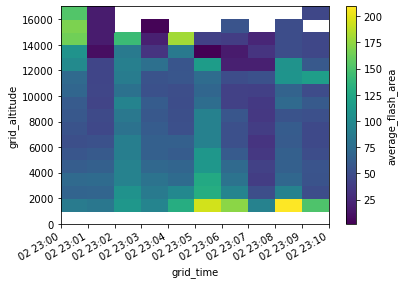

In [16]:
grid_ds.average_flashaa_area.T.plot()

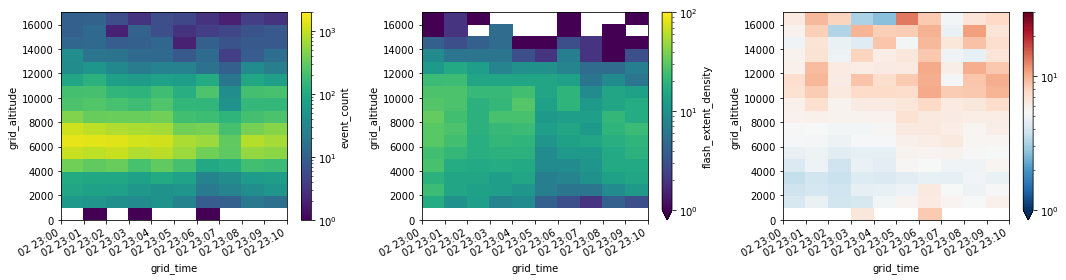

In [94]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(15,4))
grid_ds.event_count.T.plot(norm=LogNorm(vmin=1, vmax=2000), ax=axs[0])
grid_ds.flash_extent_density.T.plot(norm=LogNorm(vmin=1, vmax=100), ax=axs[1])
(grid_ds.event_total_power/grid_ds.event_count).T.plot(norm=LogNorm(vmin=1, vmax=30), ax=axs[2])
fig.tight_layout()

**2D spatial grids; sum over time**

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


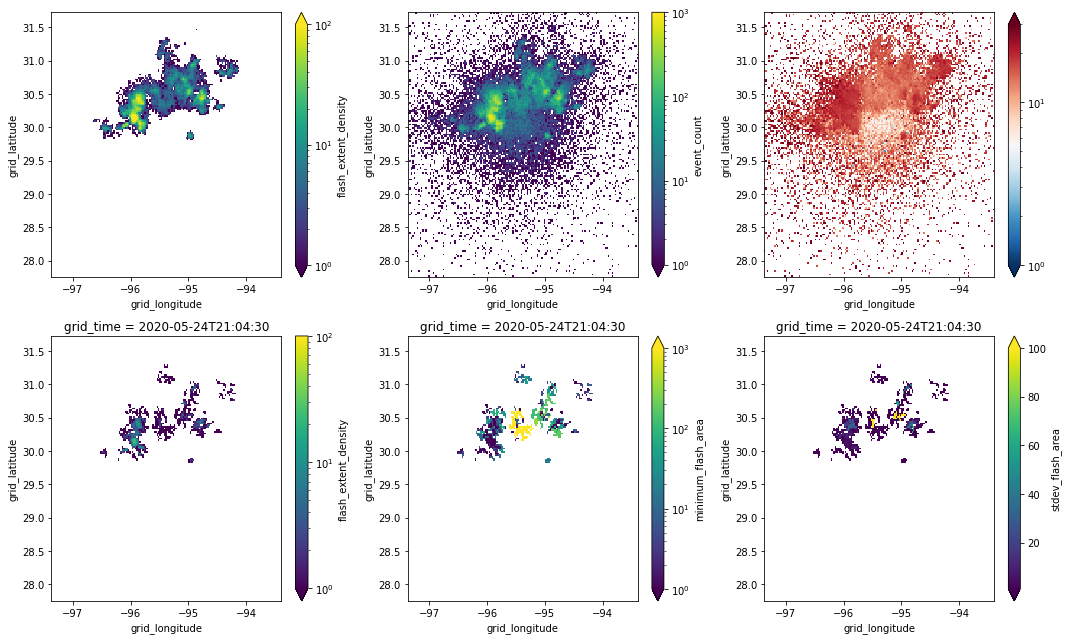

In [17]:
# empty = np.isnan(grid_ds.event_count)
# grid_ds['event_count'] = grid_ds['event_count'].fillna(0)
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3, figsize=(15,9))
axs=axs.flatten()
grid_ds.event_count.sum(axis=(0,)).plot.imshow(norm=LogNorm(vmin=1, vmax=1000), ax=axs[1])
grid_ds.flash_extent_density.sum(axis=(0,)).plot.imshow(norm=LogNorm(vmin=1, vmax=100), ax=axs[0])
(grid_ds.event_total_power.sum(axis=(0,))/grid_ds.event_count.sum(axis=(0,))).plot.imshow(norm=LogNorm(vmin=1, vmax=30), ax=axs[2])
grid_ds.flash_extent_density[4,:,:].plot.imshow(norm=LogNorm(vmin=1, vmax=100), ax=axs[3])
grid_ds.minimum_flash_area[4,:,:].plot.imshow(norm=LogNorm(vmin=1, vmax=1000), ax=axs[4])
grid_ds.stdev_flash_area[4,:,:].plot.imshow(vmin=1, vmax=100, ax=axs[5])

fig.tight_layout()

In [20]:
both_ds = xr.combine_by_coords((grid_ds, ds))

In [24]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in both_ds.data_vars}
both_ds.to_netcdf('/data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.nc', encoding=encoding)

In [26]:
ls -lh /data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.nc

-rw-r--r--  1 ebruning  staff   4.6M Jul 24 15:23 /data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.nc


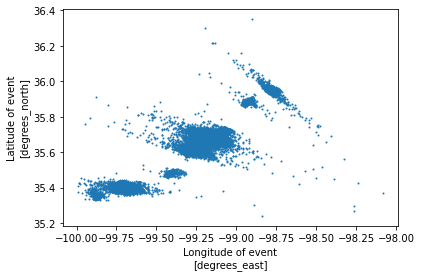

In [89]:
ds.plot.scatter('event_longitude', 'event_latitude', s=1)#, c='event_altitude')

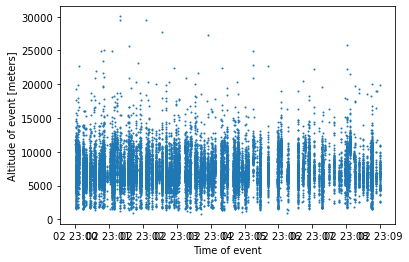

In [88]:
ds.plot.scatter('event_time', 'event_altitude', s=1)#, c='event_altitude')